In [62]:
# Import necessary libraries
import pickle
import numpy as np
import tensorflow as tf

In [63]:
# Load the Dataset

with open('train_qa.txt', 'rb') as train_file:
    train_data = pickle.load(train_file)

with open('test_qa.txt', 'rb') as test_file:
    test_data = pickle.load(test_file)

In [64]:
type(test_data)

list

In [65]:
type(train_data)

list

In [66]:
len(train_data)

10000

In [67]:
len(test_data)

1000

In [68]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [69]:
' '.join(train_data[0][0]) # 1st story

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [70]:
' '.join(train_data[0][1]) # 1st question

'Is Sandra in the hallway ?'

In [71]:
train_data[0][2] # 1st answer

'no'

In [72]:
# Creating a vocabulary of all words
vocab = set()
all_data = test_data + train_data

for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

vocab.add('no')
vocab.add('yes')

In [73]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [74]:
vocab_len = len(vocab) + 1 # we add an extra space to hold a 0 for Keras's pad_sequences

In [75]:
max_story_len = max([len(data[0]) for data in all_data])

In [76]:
max_story_len

156

In [77]:
max_question_len = max([len(data[1]) for data in all_data])

In [78]:
max_question_len

6

Vectorizing the data

In [79]:
# Reserve 0 for pad_sequences
vocab_size = len(vocab) + 1

In [80]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [81]:
# integer encode sequences of words
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [82]:
tokenizer.word_index

{'garden': 1,
 'in': 2,
 'bedroom': 3,
 'yes': 4,
 'discarded': 5,
 'to': 6,
 'put': 7,
 'grabbed': 8,
 'mary': 9,
 'hallway': 10,
 'back': 11,
 'left': 12,
 'journeyed': 13,
 'no': 14,
 'down': 15,
 '.': 16,
 'took': 17,
 'moved': 18,
 'john': 19,
 'sandra': 20,
 'milk': 21,
 '?': 22,
 'travelled': 23,
 'daniel': 24,
 'office': 25,
 'got': 26,
 'kitchen': 27,
 'went': 28,
 'apple': 29,
 'there': 30,
 'is': 31,
 'football': 32,
 'picked': 33,
 'dropped': 34,
 'the': 35,
 'up': 36,
 'bathroom': 37}

In [83]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [84]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [85]:
len(train_story_text)

10000

In [86]:
len(train_story_seq)

10000

In [87]:
# word_index = tokenizer.word_index

Functionalize Vectorization

In [88]:
# 
    # INPUT: 
    
    # data: consisting of Stories,Queries,and Answers
    # word_index: word index dictionary from tokenizer
    # max_story_len: the length of the longest story (used for pad_sequences function)
    # max_question_len: length of the longest question (used for pad_sequences function)


    # OUTPUT:
    
    # Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    # answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    # output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    # Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    
    # 

def vectorize(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):    
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [89]:
inputs_train, queries_train, answers_train = vectorize(train_data)

In [90]:
inputs_test, queries_test, answers_test = vectorize(test_data)

In [91]:
inputs_test

array([[ 0,  0,  0, ..., 35,  3, 16],
       [ 0,  0,  0, ..., 35,  1, 16],
       [ 0,  0,  0, ..., 35,  1, 16],
       ...,
       [ 0,  0,  0, ..., 35, 29, 16],
       [ 0,  0,  0, ..., 35,  1, 16],
       [ 0,  0,  0, ..., 29, 30, 16]])

In [92]:
queries_test

array([[31, 19,  2, 35, 27, 22],
       [31, 19,  2, 35, 27, 22],
       [31, 19,  2, 35,  1, 22],
       ...,
       [31,  9,  2, 35,  3, 22],
       [31, 20,  2, 35,  1, 22],
       [31,  9,  2, 35,  1, 22]])

In [93]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [94]:
sum(answers_test)

array([  0.,   0.,   0.,   0., 497.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0., 503.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [95]:
tokenizer.word_index['yes']

4

In [96]:
tokenizer.word_index['no']

14

Creating the model

In [97]:
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

Placeholders for Inputs

We have two inputs, stories and questions. So we need to use placeholders. Input() is used to instantiate a Keras tensor.

In [98]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

Building the Network

Encoders

Input Encoder m

In [99]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

Input Encoder c

In [100]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

Question Encoder

In [101]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

Encode the Sequences

In [102]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [103]:
# shape: `(samples, story_maxlen, query_maxlen)`
# Use dot product to compute the match between first input vector seq and the query
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [104]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

Concatenate

In [105]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [106]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate_1')>

In [107]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

In [108]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [109]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [110]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 156)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, None, 64)             2432      ['input_3[0][0]']             
                                                                                                  
 sequential_5 (Sequential)   (None, 6, 64)                2432      ['input_4[0][0]']             
                                                                                            

In [111]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/120


313/313 [==============================] - 4s 8ms/step - loss: 0.9018 - accuracy: 0.4910 - val_loss: 0.6977 - val_accuracy: 0.4970
Epoch 2/120
313/313 [==============================] - 2s 6ms/step - loss: 0.7077 - accuracy: 0.4942 - val_loss: 0.6950 - val_accuracy: 0.5030
Epoch 3/120
313/313 [==============================] - 2s 6ms/step - loss: 0.6977 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 4/120
313/313 [==============================] - 2s 6ms/step - loss: 0.6962 - accuracy: 0.4964 - val_loss: 0.6946 - val_accuracy: 0.5030
Epoch 5/120
313/313 [==============================] - 2s 6ms/step - loss: 0.6952 - accuracy: 0.5101 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 6/120
313/313 [==============================] - 2s 5ms/step - loss: 0.6957 - accuracy: 0.4995 - val_loss: 0.6941 - val_accuracy: 0.5030
Epoch 7/120
313/313 [==============================] - 2s 5ms/step - loss: 0.6955 - accuracy: 0.4971 - val_loss: 0.6984 - val_accuracy: 0.4970
Epoch 8/120

Saving the model

In [112]:
filename = 'chatbot_120_epochs.h5'
model.save(filename)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluating the model

Plotting training history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


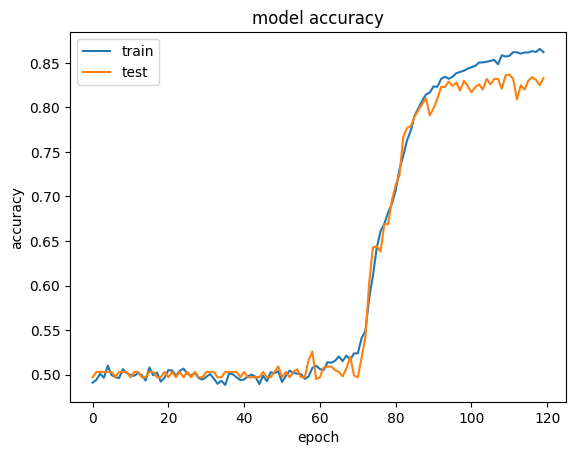

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluating on Given Test Set

In [114]:
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

sample = 0

32/32 [==============================] - 0s 2ms/step


In [115]:
test_data[sample][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [116]:
story =' '.join(word for word in test_data[sample][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [117]:
query = ' '.join(word for word in test_data[sample][1])
print(query)

Is John in the kitchen ?


In [118]:
print("True Test Answer from Data is:",test_data[sample][2])

True Test Answer from Data is: no


In [119]:
#Generate prediction from model
val_max = np.argmax(pred_results[sample])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[sample][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9973992


In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

for i, (story, question, actual_answer) in enumerate(test_data):
    # Get the index of the word with the highest predicted probability
    predicted_index = np.argmax(pred_results[i])

    # Find the corresponding word in the tokenizer's vocabulary
    predicted_word = next((word for word, index in tokenizer.word_index.items() if index == predicted_index), None)

    # Append true label and predicted label to the lists
    true_labels.append(actual_answer)
    predicted_labels.append(predicted_word)

# Convert labels to numeric format if needed
# This is necessary for some metric functions
true_numeric = tokenizer.texts_to_sequences(true_labels)
predicted_numeric = tokenizer.texts_to_sequences(predicted_labels)

# Flatten the lists to 1D arrays
true_numeric_flat = [item for sublist in true_numeric for item in sublist]
predicted_numeric_flat = [item for sublist in predicted_numeric for item in sublist]

# Calculate accuracy
accuracy = accuracy_score(true_numeric_flat, predicted_numeric_flat)

# Calculate precision, recall, and F1-score
precision = precision_score(true_numeric_flat, predicted_numeric_flat, average='weighted')
recall = recall_score(true_numeric_flat, predicted_numeric_flat, average='weighted')
f1 = f1_score(true_numeric_flat, predicted_numeric_flat, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Accuracy: 0.83
Precision: 0.84
Recall: 0.83
F1-score: 0.83
